In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import statistics as st
import anndata as ad
from src.functions import *
%matplotlib inline

In [2]:
dataset_co_cult = np.load('data/Mx_Co_Cultured/marks_flitered_fluo.npy', allow_pickle = True)

dict_headers = ["norm_MM",
    "cell_marks",
    "nucl_fluo",
    "cell_fluo",
    "marks_fluo",
    "marks_cell_overlap",
    "mark_area",
    "overlap_indices",
    "marks_fluo_overlap",
    "cell_area",
    "marks_cell_overlap_indexes",
    "marks_cellLabels",
    "marks_samplingArea",
    "pmi",
    "overLaps"]

cell_area = dataset_co_cult[9]

# reference, which cells are covered by which marks
cell_marks = dataset_co_cult[1]

# size of every mark
mark_area = dataset_co_cult[6]

# reference of overlap area between cells and marks
marks_cell_overlap = dataset_co_cult[5]



In [3]:
# pickles of tables that result from this comfiguration have suffix "_small"
if(False):
    selected_cells = ['3', '100', '21', '43', '547']
    cell_marks = {k:v for k,v in cell_marks.items() if k in selected_cells}
    marks_cell_overlap = {k:v for k,v in marks_cell_overlap.items() if k in selected_cells}
    selected_pixels = ['2']
    for _, cell in cell_marks.items():
        selected_pixels = selected_pixels + [str(n) for n in cell]

    selected_pixels.sort(key = int)
    mark_area = {k:v for k,v in mark_area.items() if k in selected_pixels}

    selected_pixels

In [4]:
# calculating different cell x pixel matrices
overlap_matrix, sampling_prop_matrix, sampling_spec_matrix = get_matrices(mark_area=mark_area, marks_cell_associations=cell_marks, marks_cell_overlap=marks_cell_overlap)

sampling_spec_matrix

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_2490,pixel_2491,pixel_2492,pixel_2493,pixel_2494,pixel_2495,pixel_2496,pixel_2497,pixel_2498,pixel_2499
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:

ion_intensities = pd.read_csv('data/Mx_Co_Cultured/sm_annotation_detections.csv')

ion_intensities = ion_intensities.drop(['Num', 'X', 'Y', 'Z', 'R'], axis=1)

# ion_intensities = ion_intensities[['C16H30O2', "C25H44NO7P", "C45H78NO8P"]]
# ion_intensities = ion_intensities.iloc[selected_pixels]

ion_intensities.index = [PIXEL_PRE + str(i) for i in ion_intensities.index]
ion_intensities


,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
pixel_0,11732.452,996.42834,0.000000,96.63648,251.41237,1035.7161,508.46760,776.2968,728.43120,1268.3046,...,263.37576,252.51741,0.0,244.01695,0.00000,99.36901,0.0,2732.2040,1450.11540,128.282870
pixel_1,8926.941,644.85220,98.860180,94.53568,129.45300,1127.7477,660.01980,798.9810,499.13810,1126.1990,...,269.30545,126.23382,0.0,491.70282,340.28522,75.63770,0.0,4471.3240,1770.75710,400.891660
pixel_2,16184.508,1443.74080,122.435680,459.26910,298.34604,874.1114,869.47440,1570.6218,1599.04420,1897.0496,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,970.5054,616.07654,78.222760
pixel_3,17386.785,1770.08830,0.000000,521.62244,392.64360,1581.3160,851.89560,1496.8848,1700.58310,2238.6267,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,1037.3005,702.37850,0.000000
pixel_4,17993.777,2441.13100,0.000000,424.59857,589.03710,1536.0576,1004.76526,1373.1233,1684.19860,2142.4817,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,1332.7043,940.42100,120.620830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel_2495,14193.198,1098.00960,377.735440,133.33331,0.00000,1268.6356,966.20984,1225.4326,1056.80550,2004.0934,...,130.08005,229.90854,0.0,136.83795,0.00000,0.00000,0.0,4241.5864,1591.95830,317.245880
pixel_2496,17826.373,2204.89750,124.410450,604.37280,635.19990,1172.6652,2027.87210,2225.9185,2475.11870,3223.1426,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,2617.0530,1362.17570,85.987526
pixel_2497,20524.766,2208.07860,131.849640,535.55316,437.42600,1162.7046,1485.94580,1914.0786,1891.50900,3095.1462,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,3441.5498,2130.13530,101.250000
pixel_2498,13827.365,1398.90610,117.092980,228.95663,93.65218,922.5511,1030.80410,1423.4183,1002.28130,2138.9333,...,184.42477,230.75467,0.0,108.41697,0.00000,368.53442,0.0,5551.5240,2327.51880,254.901870


In [6]:
# this is how martijn performed the calculations
def cell_normalization_Rappez_matrix(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
    
    # filter out pixels with little overlap with any cell (thus sum of all overlaps)
    pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
    # filter out pixels with low contributions to a cell
    pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

    sampling_prop_matrix_filtered = sampling_prop_matrix.sum(axis = 0) * pixel_sampling_prop_keep
    sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

    sum_prop_matrix = sampling_prop_matrix_filtered.replace(to_replace=0, value=pd.NA)

    # create dataframe for results
    norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)
    norm_spots = ion_intensity_matrix.multiply(1/sum_prop_matrix, axis=0).replace(np.nan, 0)
    
    cor_df = sampling_spec_matrix_filtered.replace(np.nan, 0).dot(norm_spots)

    norm_cor_df = cor_df.multiply(1/sampling_spec_matrix_filtered.sum(axis=1), axis=0)
    
    return norm_cor_df



In [7]:
norm_ion_intensities = cell_normalization_Rappez_matrix(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities)

In [8]:

total_pixel_overlap, full_pixel_intensities_median = get_molecule_normalization_factors(intensities_df = ion_intensities, overlap_matrix = sampling_prop_matrix, method = st.median)
_, full_pixel_intensities_mean = get_molecule_normalization_factors(intensities_df = ion_intensities, overlap_matrix = sampling_prop_matrix, method = st.mean)
_, full_pixel_intensities_75th = get_molecule_normalization_factors(intensities_df = ion_intensities, overlap_matrix = sampling_prop_matrix, method = lambda x: np.percentile(x, 75))

full_pixel_intensities = full_pixel_intensities_mean
full_pixel_intensities

C10H10N2O3S    8689.777254
C10H10N2O4S     744.092127
C12H13N3O4S     163.430032
C12H20N3O6S      80.215007
C13H16N2O5      167.723006
                  ...     
C46H81NO10P      72.739987
C50H84NO10P      61.468594
C6H11O8P       4262.701390
C6H13O9P       1811.640886
C9H19O11P       356.999531
Length: 104, dtype: float64

In [9]:
full_pixel_intensities_median.name = "full_pixels_by_median"
full_pixel_intensities_mean.name = "full_pixels_by_mean"
full_pixel_intensities_75th.name = "full_pixels_by_75th_percentile"

df = pd.concat([full_pixel_intensities_median, full_pixel_intensities_mean, full_pixel_intensities_75th], axis=1)
zeros = df.loc[(df[full_pixel_intensities_median.name] == 0) | (df[full_pixel_intensities_mean.name] == 0) | ( df[full_pixel_intensities_75th.name] == 0)]

zeros.index.intersection(['C10H10N2O3S', 'C10H10N2O4S', 'C12H13N3O4S', 'C12H20N3O6S',
       'C13H16N2O5', 'C13H26O2', 'C14H20N2O3S', 'C14H20N2O4S', 'C14H20N2O6S',
       'C14H21N3O3S', 'C14H23N2O8', 'C14H28O2', 'C14H29NaO4S', 'C15H18O12',
       'C15H22O2', 'C15H30O2', 'C16H12N2', 'C16H15F2N3Si', 'C16H32O2',
       'C17H17ClN4', 'C18H13N3O', 'C20H12N2O2', 'C20H14N4', 'C20H18N4O2',
       'C20H32N5O8P', 'C21H20N4O2', 'C25H34O3', 'C25H36O2', 'C25H36O3',
       'C26H31NO11', 'C27H46O4', 'C34H38O16', 'C34H70NO6P', 'C39H36N4O7',
       'C39H78NO8P', 'C41H79O13P', 'C41H82NO7P', 'C42H79O10P', 'C43H74NO7P',
       'C43H74NO8P', 'C45H76NO7P', 'C45H78NO7P', 'C45H82NO7P', 'C46H77O10P',
       'C46H81NO10P', 'C50H84NO10P'])



Index(['C16H12N2', 'C34H70NO6P', 'C39H36N4O7', 'C41H79O13P', 'C41H82NO7P',
       'C42H79O10P', 'C43H74NO7P', 'C43H74NO8P', 'C45H76NO7P', 'C45H78NO7P',
       'C45H82NO7P', 'C46H77O10P', 'C46H81NO10P', 'C50H84NO10P'],
      dtype='object')

In [10]:
total_pixel_overlap

pixel_0       0.000000
pixel_1       0.013177
pixel_2       0.000000
pixel_3       0.000000
pixel_4       0.000000
                ...   
pixel_2495    0.844884
pixel_2496    0.000000
pixel_2497    0.874794
pixel_2498    0.779715
pixel_2499    1.000000
Name: total_pixel_area, Length: 2500, dtype: float64

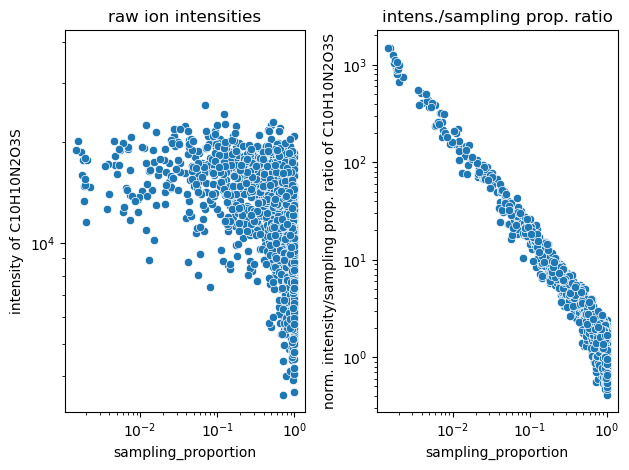

In [11]:

def log_log_regression_plot(df, molecule = '', x_axis= total_pixel_overlap, x_axis_name='sampling_proportion', title = 'Regression plot'):
    intensities_df = df.copy()

    norm_intensity_prop_ratios_df = normalize_proportion_ratios(intensities_df, pixels_total_overlap=x_axis, full_pixels_avg_intensities=full_pixel_intensities, normalized=True)
    intensities_df[x_axis_name] = total_pixel_overlap
    norm_intensity_prop_ratios_df[x_axis_name] = total_pixel_overlap

    if not molecule in intensities_df.columns:
        molecule = intensities_df.columns[0]

    fig, ax = plt.subplots(1, 2)

    def render_plot(df, ax, measure, title = ''):

        sns.scatterplot(data=df.dropna(subset = [molecule, x_axis_name]).infer_objects(), x=x_axis_name, y=molecule, ax=ax)
        ax.set(xscale="log")
        ax.set(yscale="log")
        ax.set(ylabel= measure + " of " + molecule)
        ax.set(title=title)

    render_plot(intensities_df, ax[0], measure = 'intensity', title = title)
    render_plot(norm_intensity_prop_ratios_df, ax[1], measure = 'norm. intensity/sampling prop. ratio', title='intens./sampling prop. ratio')

    fig.tight_layout()


log_log_regression_plot(ion_intensities, title = 'raw ion intensities')

In [12]:
corrected_intensities = correct_intensities_quantile_regression(ion_intensities, 
    pixels_total_overlap=total_pixel_overlap, 
    full_pixels_avg_intensities=full_pixel_intensities, 
    reference_ions = ['C21H43O7P'])
    

/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


C34H70NO6P has not enough datapoints. using reference pool instead


/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


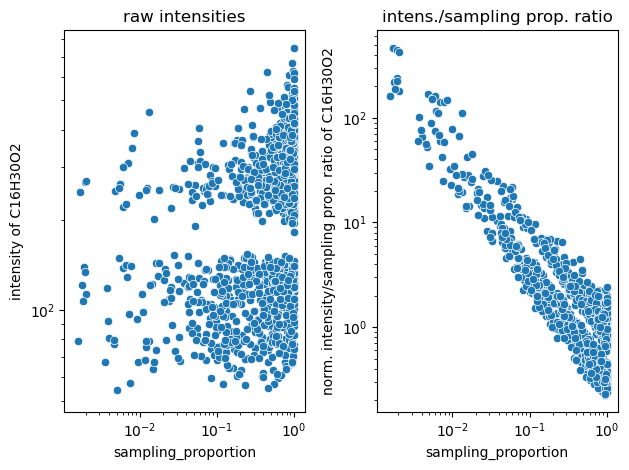

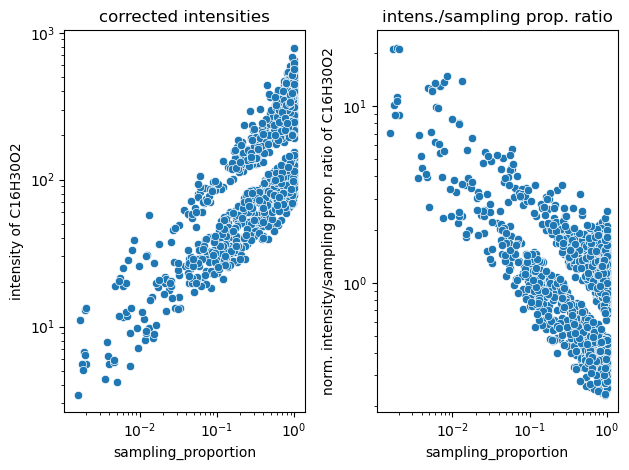

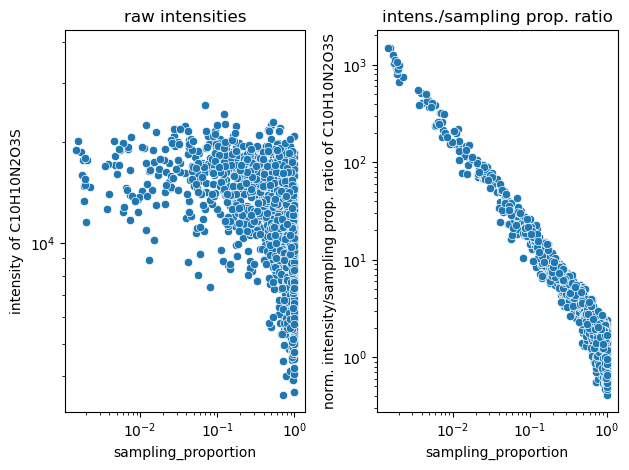

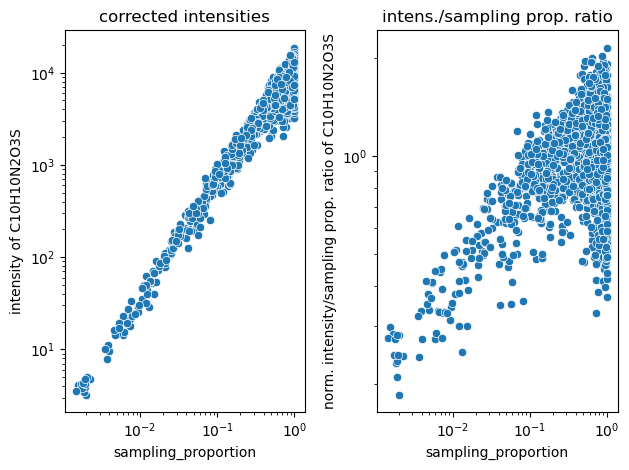

In [13]:
log_log_regression_plot(ion_intensities, molecule='C16H30O2', title='raw intensities')
log_log_regression_plot(corrected_intensities, molecule='C16H30O2', title='corrected intensities')

log_log_regression_plot(ion_intensities, molecule='C10H10N2O3S', title='raw intensities')
log_log_regression_plot(corrected_intensities, molecule='C10H10N2O3S', title='corrected intensities')

In [14]:
corrected_intensities.to_pickle("data/Mx_Co_Cultured/corrected_ion_intensities.pkl")
ion_intensities.to_pickle("data/Mx_Co_Cultured/raw_ion_intensities.pkl")

In [15]:
norm_corr_ion_intensities = cell_normalization_Rappez_matrix(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=corrected_intensities)
norm_corr_ion_intensities.dropna()

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_11,10676.450130,1046.315040,229.084157,90.570689,325.179074,1373.868077,436.227491,896.657425,704.926570,1121.549991,...,0.000000,0.000000,0.0,0.000000,30.001803,0.00000,0.0,1916.826026,1122.119478,85.799815
cell_13,12422.741449,1221.739353,155.424577,128.113853,342.573733,1206.268626,497.470682,1007.500179,902.221368,1475.141200,...,0.000000,107.276930,0.0,0.000000,14.906753,0.00000,0.0,1666.749394,1050.648876,42.630661
cell_14,9293.039079,1352.761951,0.000000,149.697832,204.601171,1140.408284,679.643386,753.094640,658.848240,978.670815,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,2614.323763,1088.178685,195.378334
cell_15,14008.587629,1373.823245,92.071589,159.458091,350.726086,1033.119688,556.956169,1111.245789,1088.469468,1799.131056,...,0.000000,203.524064,0.0,0.000000,0.000000,0.00000,0.0,1462.769645,981.729592,6.916737
cell_16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1500,8595.547160,827.847289,122.196521,86.257594,164.135775,1106.285657,622.078311,1074.880877,582.159292,1336.105285,...,78.015028,174.405160,0.0,36.381461,69.374974,0.00000,0.0,3750.617494,2257.608157,197.446630
cell_1503,13903.643695,1260.998797,227.332043,145.607231,161.825078,1293.401165,983.649529,1296.886330,941.060487,2248.208614,...,24.775101,153.707928,0.0,0.000000,0.000000,0.00000,0.0,4266.942902,2136.045716,177.175896
cell_1510,7448.972524,657.827177,55.112530,0.000000,47.863204,1109.847892,501.658077,694.640076,210.041163,1207.969456,...,236.552314,202.099904,0.0,365.458974,0.000000,121.68758,0.0,9273.031016,3689.695903,815.860019
cell_1512,7561.405714,677.932967,63.710148,10.982945,61.549961,1109.845052,517.111561,740.006035,252.765307,1218.752710,...,209.911471,192.204069,0.0,324.300487,9.474157,107.98296,0.0,8649.729832,3539.090117,741.186413


In [16]:
norm_ion_intensities.dropna().to_pickle('data/Mx_Co_Cultured/normalized_ion_intensities.pkl')
norm_corr_ion_intensities.dropna().to_pickle('data/Mx_Co_Cultured/normalized_corrected_ion_intensities.pkl')

In [17]:
norm_corr_ion_intensities

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
